In [2]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

In [5]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [6]:
#Dataloader

#Path for training and testing directory
train_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_train'
test_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_test'
#predict_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_predict'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [7]:
#Dataloader

#Path for training and testing directory
train_path_1='C:/Users/black/Desktop/Size/size_train'
test_path_1='C:/Users/black/Desktop/Size/size_test'
#predict_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_predict'

train_loader_1=DataLoader(
    torchvision.datasets.ImageFolder(train_path_1,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader_1=DataLoader(
    torchvision.datasets.ImageFolder(test_path_1,transform=transformer),
    batch_size=32, shuffle=True
)

In [8]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [9]:
#categories
root=pathlib.Path(train_path_1)
classes_1=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [10]:
print(classes)

In [11]:
print(classes_1)

In [12]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)  
        output=self.pool(output)   
        output=self.conv2(output)
        output=self.relu2(output)    
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)    
        output=output.view(-1,32*75*75)   
        output=self.fc(output)   
        return output
            
        


In [13]:
#Optmizer and loss function
model = ConvNet(num_classes=6)
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [14]:
#Optmizer and loss function
model_1= ConvNet(num_classes=6)
optimizer_1=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function_1=nn.CrossEntropyLoss()

In [15]:
num_epochs=20

In [16]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.tiff'))
test_count=len(glob.glob(test_path+'/**/*.tiff'))

In [17]:
#calculating the size of training and testing images
train_count_1=len(glob.glob(train_path_1+'/**/*.tiff'))
test_count_1=len(glob.glob(test_path_1+'/**/*.tiff'))

In [18]:
print(train_count,test_count)

In [19]:
print(train_count_1,test_count_1)

Epoch: 0 Train Loss: tensor(5.0543) Train Accuracy: 0.7139130434782609 Test Accuracy: 0.9529411764705882
Epoch: 1 Train Loss: tensor(0.5455) Train Accuracy: 0.9217391304347826 Test Accuracy: 0.95


NameError: name 'val_loss_values' is not defined

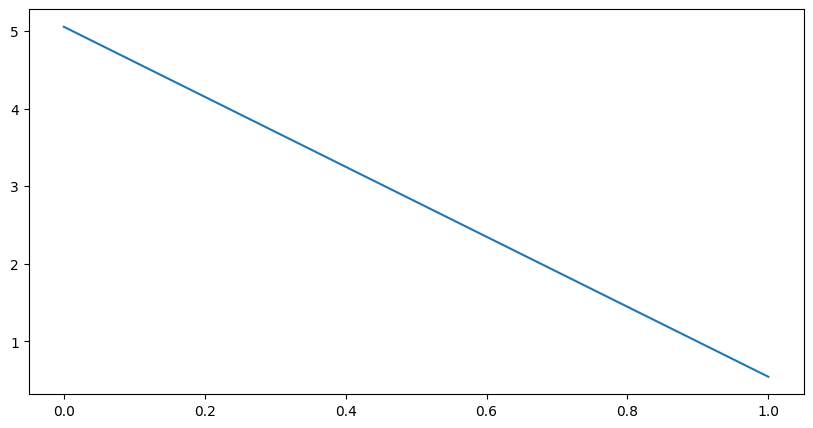

In [19]:
best_accuracy = 0.0
train_loss_values = []  # Define an empty list to store training loss values

for epoch in range(num_epochs):
    
    # Evaluation and training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count
    train_loss_values.append(train_loss)  # Append training loss to the list
    
    # Evaluation on the testing dataset
    model.eval()
    
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))
    
    test_accuracy = test_accuracy / test_count
    
    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))
    
    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint_gender.model')
        best_accuracy = test_accuracy
        
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch: 1 Train Loss: tensor(7.0366e-06) Train Accuracy: 1.0 Val Loss: tensor(4.7263) Val Accuracy: 0.7088235294117647
Epoch: 2 Train Loss: tensor(1.0305e-05) Train Accuracy: 1.0 Val Loss: tensor(3.7837) Val Accuracy: 0.7441176470588236
Epoch: 3 Train Loss: tensor(5.1719e-06) Train Accuracy: 1.0 Val Loss: tensor(3.7411) Val Accuracy: 0.7588235294117647
Epoch: 4 Train Loss: tensor(1.7652e-05) Train Accuracy: 1.0 Val Loss: tensor(3.6116) Val Accuracy: 0.7617647058823529
Epoch: 5 Train Loss: tensor(8.0842e-06) Train Accuracy: 1.0 Val Loss: tensor(3.5508) Val Accuracy: 0.7529411764705882
Epoch: 6 Train Loss: tensor(6.3177e-06) Train Accuracy: 1.0 Val Loss: tensor(3.6562) Val Accuracy: 0.7617647058823529
Epoch: 7 Train Loss: tensor(6.7019e-06) Train Accuracy: 1.0 Val Loss: tensor(3.5524) Val Accuracy: 0.7617647058823529
Epoch: 8 Train Loss: tensor(1.5805e-05) Train Accuracy: 1.0 Val Loss: tensor(3.6947) Val Accuracy: 0.7588235294117647
Epoch: 9 Train Loss: tensor(4.6285e-06) Train Accuracy: 

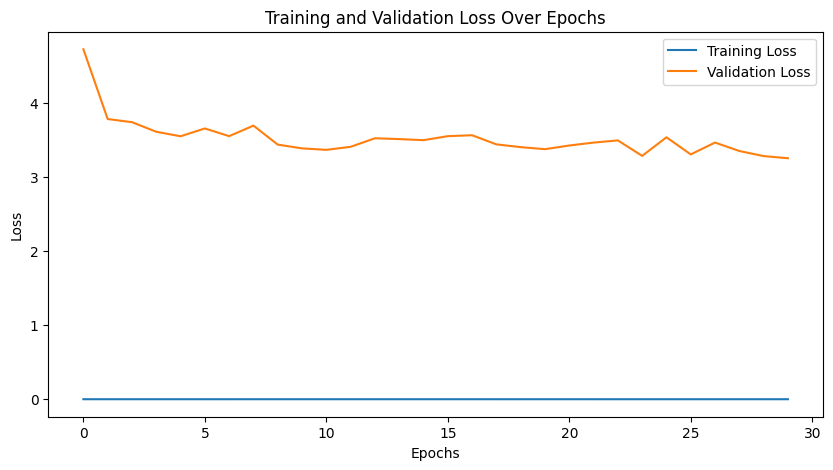

In [27]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming you have defined train_loader and test_loader for training and testing datasets

best_accuracy = 0.0
train_loss_values = []  # Store training loss values
val_loss_values = []    # Store validation loss values

num_epochs = 30  # Number of epochs

for epoch in range(num_epochs):
    
    # Training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_values.append(train_loss)
    
    # Validation on the testing dataset
    model.eval()
    
    val_accuracy = 0.0
    val_loss = 0.0
    
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy += int(torch.sum(prediction == labels.data))
    
    val_accuracy = val_accuracy / len(test_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    val_loss_values.append(val_loss)
    
    print('Epoch:', epoch+1, 'Train Loss:', train_loss, 'Train Accuracy:', train_accuracy, 'Val Loss:', val_loss, 'Val Accuracy:', val_accuracy)
    
    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint_gender.model')
        best_accuracy = val_accuracy

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming you have defined train_loader and test_loader for training and testing datasets
# Assuming model, optimizer, and loss_function are defined

best_accuracy = 0.0
train_loss_values = []  # Store training loss values
val_loss_values = []    # Store validation loss values
train_acc_values = []   # Store training accuracy values
val_acc_values = []     # Store validation accuracy values

num_epochs = 30  # Number of epochs

for epoch in range(num_epochs):
    
    # Training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_accuracy)
    
    # Validation on the testing dataset
    model.eval()
    
    val_accuracy = 0.0
    val_loss = 0.0
    
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy += int(torch.sum(prediction == labels.data))
    
    val_accuracy = val_accuracy / len(test_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    val_loss_values.append(val_loss)
    val_acc_values.append(val_accuracy)
    
    print('Epoch:', epoch+1, 'Train Loss:', train_loss, 'Train Accuracy:', train_accuracy, 'Val Loss:', val_loss, 'Val Accuracy:', val_accuracy)
    
    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint_gender.model')
        best_accuracy = val_accuracy

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_values)), train_acc_values, label='Training Accuracy')
plt.plot(range(len(val_acc_values)), val_acc_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch: 0 Train Loss: tensor(1.8083e-05) Train Accuracy: 1.0 Test Accuracy: 0.7411764705882353


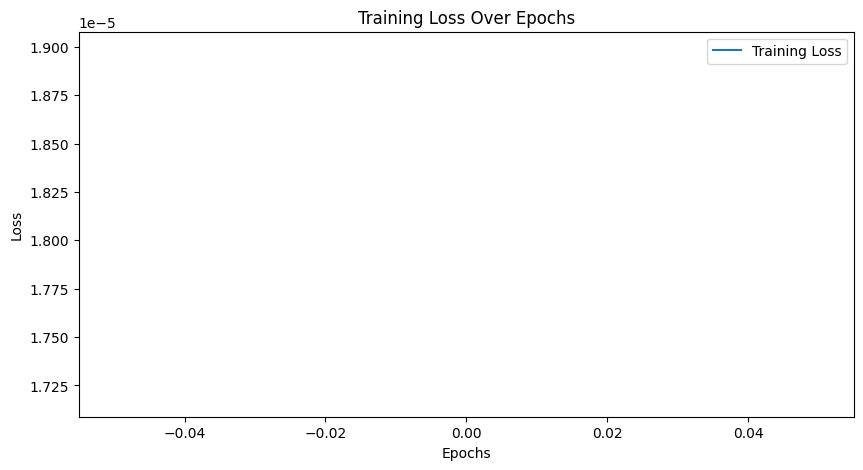

In [26]:
best_accuracy = 0.0
train_loss_values = []  # Define an empty list to store training loss values

for epoch in range(num_epochs):
    
    # Evaluation and training on the training dataset
    model_1.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function_1(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count
    train_loss_values.append(train_loss)  # Append training loss to the list
    
    # Evaluation on the testing dataset
    model_1.eval()
    
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))
    
    test_accuracy = test_accuracy / test_count
    
    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))
    
    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint_size.model')
        best_accuracy = test_accuracy
        
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Function to calculate metrics
def calculate_metrics(loader, dataset_count):
    model.eval()
    all_predictions = []
    all_labels = []
    for i, (images, labels) in enumerate(loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        outputs = model(images)
        _, predictions = torch.max(outputs.data, 1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    confusion = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, f1, precision, recall, confusion

# Your existing code up to the training loop...

# Training loop...
# (Your existing training loop code)

# Calculate metrics for training set
train_accuracy, train_f1, train_precision, train_recall, train_confusion = calculate_metrics(train_loader, train_count)
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training Confusion Matrix:\n", train_confusion)

# Calculate metrics for testing set
test_accuracy, test_f1, test_precision, test_recall, test_confusion = calculate_metrics(test_loader_1, test_count)
print("\nTesting Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing Confusion Matrix:\n", test_confusion)



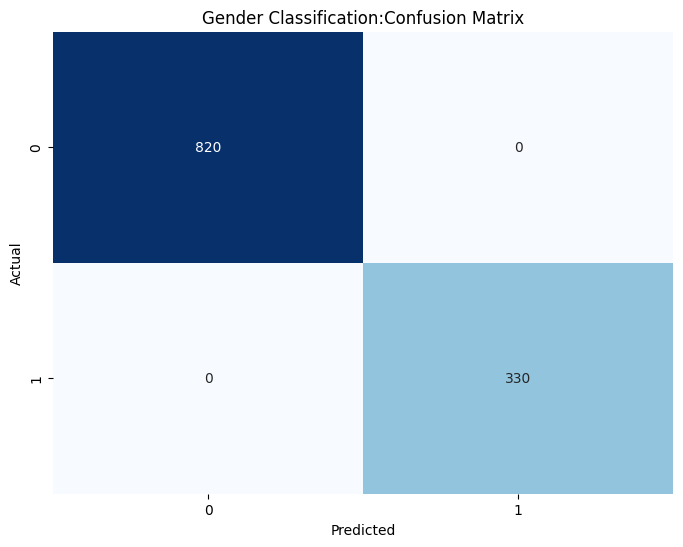

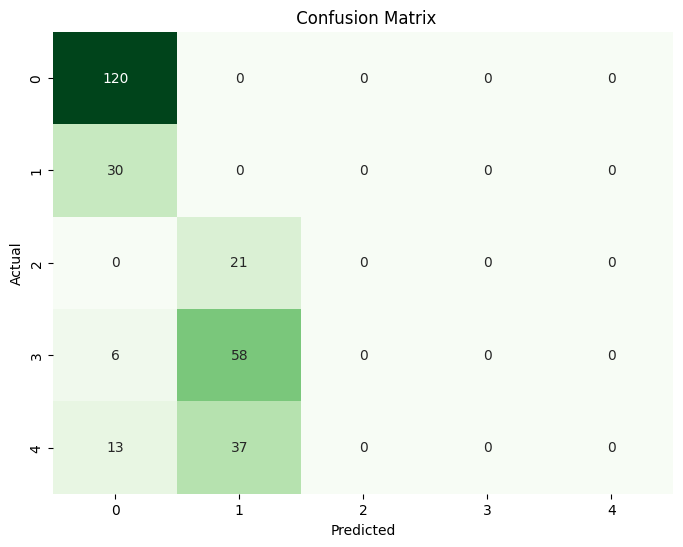

In [34]:
import seaborn as sns

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Gender Classification:Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion, annot=True, cmap='Greens', fmt='d', cbar=False)
plt.title(' Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Function to calculate metrics
def calculate_metrics(loader, dataset_count):
    model.eval()
    all_predictions = []
    all_labels = []
    for i, (images, labels) in enumerate(loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        outputs = model(images)
        _, predictions = torch.max(outputs.data, 1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    confusion = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, f1, precision, recall, confusion

In [ ]:
# Calculate metrics for testing set
test_accuracy, test_f1, test_precision, test_recall, test_confusion = calculate_metrics(test_loader_1, test_count)
print("\nTesting Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing Confusion Matrix:\n", test_confusion)

In [ ]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming you have defined train_loader and test_loader for training and testing datasets
# Assuming model, optimizer, and loss_function are defined

best_accuracy = 0.0
train_loss_values = []  # Store training loss values
val_loss_values = []    # Store validation loss values
train_acc_values = []   # Store training accuracy values
val_acc_values = []     # Store validation accuracy values

num_epochs = 30  # Number of epochs

for epoch in range(num_epochs):
    
    # Training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        
        train_accuracy += int(torch.sum(prediction == labels.data))
        
    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_accuracy)
    
    # Validation on the testing dataset
    model.eval()
    
    val_accuracy = 0.0
    val_loss = 0.0
    
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy += int(torch.sum(prediction == labels.data))
    
    val_accuracy = val_accuracy / len(test_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    val_loss_values.append(val_loss)
    val_acc_values.append(val_accuracy)
    
    print('Epoch:', epoch+1, 'Train Loss:', train_loss, 'Train Accuracy:', train_accuracy, 'Val Loss:', val_loss, 'Val Accuracy:', val_accuracy)
    
    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint_gender.model')
        best_accuracy = val_accuracy

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss_values)), train_loss_values, label='Training Loss')
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_values)), train_acc_values, label='Training Accuracy')
plt.plot(range(len(val_acc_values)), val_acc_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
